## Project-Specific Research
1. How many users do we have who have only made a purchase once
2. How many orders per month, on average, are not delivered for various reasons (itemize by reason)?   
3. For each product, determine on which day of the week the product is most often purchased.
4. How many purchases each user has on average per week (by month)?
5. Using pandas, conduct a cohort analysis of users. Identify the cohort with the highest retention for the 3rd month between January and December.
6.  Using Python, build an RFM-based user segmentation to assess your audience qualitatively.

In [7]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

In [8]:
orders = pd.read_csv('olist_orders_dataset.csv', 
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                  'order_delivered_carrier_date', 'order_delivered_customer_date',
                                 'order_estimated_delivery_date'])

items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

customers = pd.read_csv('olist_customers_dataset.csv')

### 1. How many users do we have who have only made a purchase once?

Let's take only the data we consider as purchases from orders.

Since we consider `customer_unique_id` to be unique users, let's join the tables, having previously selected the necessary customer data.

In [9]:
purchases = orders.loc[orders.order_status.isin(['delivered', 'shipped'])]
purchases_users = customers[['customer_id', 'customer_unique_id']].merge(purchases, on='customer_id', how='left')

Let's count the number of purchases and get one-time ones.

In [10]:
one_purch = purchases_users.groupby('customer_unique_id', as_index = False).order_id.count().query("order_id == 1")
one_purch.shape

(91538, 2)

We obtained 91538 unique users. We can be sure that the users are unique because this field has already grouped the data.

We can also output the number of unique users to be sure.


In [11]:
one_purch.customer_unique_id.count()

91538

**Answer** - 91538

---

### 2. How many orders per month, on average, are not delivered for various reasons (itemized by reason)?

Let's select the data on orders that have yet to be delivered.

In [12]:
not_delivered = orders.loc[~(orders.order_status == 'delivered')].copy()

Let's take the date of purchase as the month. We will group by month and reason, count the number by month, then group again by reason, count the average for all months, and sort in descending order.

In [13]:
not_delivered['purch_my'] = not_delivered.order_purchase_timestamp.dt.to_period('M')
not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purch_my
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01


In [14]:
month_num = not_delivered.purch_my.nunique()

In [15]:
not_delivered_my = not_delivered.groupby('order_status', as_index=False).agg(orders=('order_id','count'))
not_delivered_my['per_month'] = not_delivered_my.orders / month_num
not_delivered_my = not_delivered_my.sort_values('per_month', ascending=False)
not_delivered_my

,order_status,orders,per_month
5,shipped,1107,46.125000
1,canceled,625,26.041667
6,unavailable,609,25.375000
3,invoiced,314,13.083333
4,processing,301,12.541667
2,created,5,0.208333
0,approved,2,0.083333


/var/folders/qp/pbljlgmj5vj88c5rdfd11b480000gn/T/ipykernel_7140/3966506739.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=not_delivered_my, x='order_status', y='per_month', palette='viridis')


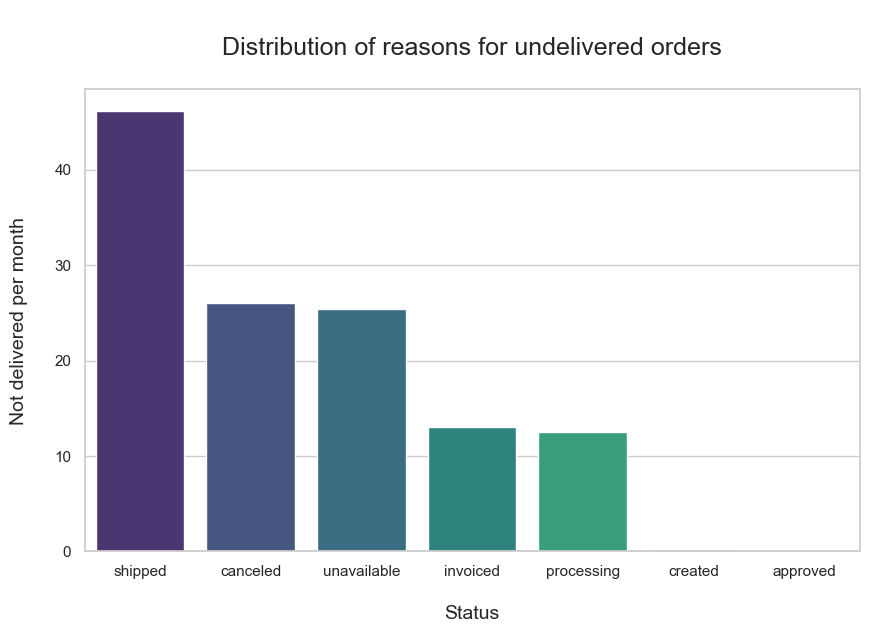

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(data=not_delivered_my, x='order_status', y='per_month', palette='viridis')

plt.xlabel('\nStatus', fontsize=14)
plt.ylabel('Not delivered per month\n', fontsize=14)
plt.title('\nDistribution of reasons for undelivered orders\n', fontsize=18)
plt.show()

Orders with `shipped` statuses are in transit, `invoiced` and `processing` - in process, `created` and `approved` were just created, so as `undelivered`, we will consider `canceled` and `unavailable` statuses.

**Answer**:
- About 25 orders on average per month are not delivered due to unavailability
- About 26 orders on average per month are not delivered due to cancellation

---

### 3. For each product, determine on which day of the week the product is most often purchased.

Let's add order dates to the items table.

In [17]:
items = items.merge(orders[['order_purchase_timestamp', 'order_id']], on='order_id')

Let's add a column with the day of the week to the items table.

In [18]:
items['weekday'] = items.order_purchase_timestamp.dt.strftime("%A")
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,Saturday


Group by `product_id` and `purch_weekday`, then count the number of purchases on each day of the week.

In [19]:
items_by_weekday = items.groupby(['product_id', 'weekday'], as_index=False) \
                        .agg({'order_purchase_timestamp': 'count'}) \
                        .rename(columns={'order_purchase_timestamp':'purchases'})
items_by_weekday.head()

,product_id,weekday,purchases
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


Let's leave only the days with the maximum number of purchases for each product. If there is more than one such day, we will display all of them, rename the columns, and remove brackets for better readability.

In [20]:
top_days = items_by_weekday[items_by_weekday['purchases'] == items_by_weekday['product_id'] \
                        .map(items_by_weekday.groupby('product_id').purchases.max())] \
                        .groupby('product_id', as_index=False).agg({'weekday': list, 'purchases': max}) \
                        .rename(columns={'weekday':'week_days', 'purchases':'max_purchases'})
top_days['week_days'] = top_days.week_days.apply(lambda x: ', '.join(x))
top_days.tail()

/var/folders/qp/pbljlgmj5vj88c5rdfd11b480000gn/T/ipykernel_7140/3060446887.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .groupby('product_id', as_index=False).agg({'weekday': list, 'purchases': max}) \


,product_id,week_days,max_purchases
32946,fff6177642830a9a94a0f2cba5e476d1,"Saturday, Sunday",1
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
32948,fff9553ac224cec9d15d49f5a263411f,Friday,1
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
32950,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1


**Answer**

Now we can refer to this table when we are interested in the shopping days of any products.

We can also see on which days more people buy in general.

In [21]:
weekdays_purch = items_by_weekday.groupby('weekday').purchases.sum().to_frame().reset_index()

/var/folders/qp/pbljlgmj5vj88c5rdfd11b480000gn/T/ipykernel_7140/4197647742.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday', y='purchases', data=weekdays_purch, order=weekday_order, palette='viridis')


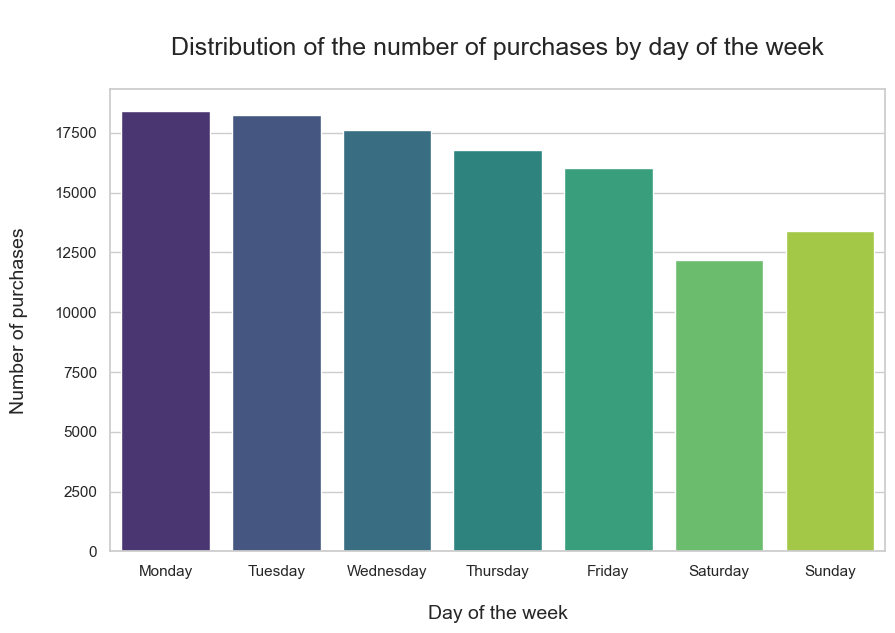

In [22]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(x='weekday', y='purchases', data=weekdays_purch, order=weekday_order, palette='viridis')
plt.xlabel('\nDay of the week', fontsize=14)
plt.ylabel('Number of purchases\n', fontsize=14)
plt.title('\nDistribution of the number of purchases by day of the week\n', fontsize=18)
plt.show()

**Answer**

The most purchases are made on Monday, the least on Saturday.

To consider the top day for each product, we can refer to the table by product id.

---

### 4. How many purchases each user has on average per week (by month)? 
_Remember that there may be a partial number of weeks within a month. 
For example, November 2021 has 4.28 weeks. And within the metric, this needs to be accounted for._

Let's use the already created `purchases_users` table, which contains only the records we consider a purchase, as well as the unique ID of the customer.

In [23]:
f'''First purchase: {purchases_users.order_purchase_timestamp.min()}, last purchase:\
{purchases_users.order_purchase_timestamp.max()})'''


'First purchase: 2016-09-04 21:15:19, last purchase:2018-09-03 09:06:57)'

Let's add a column with the month.

In [24]:
purchases_users_month = purchases_users.assign(month=purchases_users['order_purchase_timestamp'].dt.to_period('M'))
purchases_users_month.head()


,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [25]:
purchases_users_month['first_or_last'] = purchases_users_month['month'].apply(lambda x: 'first' 
    if x == purchases_users_month['order_purchase_timestamp'].min()
    else ('last' if x == purchases_users_month['order_purchase_timestamp'].max() else ''))
purchases_users_month.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,first_or_last
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,


Let's calculate the number of weeks in months.

In [26]:
first_month_start = purchases_users_month[purchases_users_month['first_or_last'] == 'first']['order_purchase_timestamp'].min()
first_month_end = first_month_start + pd.offsets.MonthEnd(0)
num_weeks_first_month = (first_month_end - first_month_start).days / 7

num_weeks_last_month = purchases_users_month[purchases_users_month['first_or_last'] == 'last']['order_purchase_timestamp'].max().day / 7

purchases_users_month.loc[purchases_users_month['first_or_last'] == 'first', 'weeks'] = num_weeks_first_month
purchases_users_month.loc[purchases_users_month['first_or_last'] == 'last', 'weeks'] = num_weeks_last_month
purchases_users_month.loc[purchases_users_month['first_or_last'] == '', 'weeks'] = purchases_users_month['order_purchase_timestamp'].dt.daysinmonth/7
purchases_users_month.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,first_or_last,weeks
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,,4.428571


Group by unique ID and month, count the number of purchases each month first, then add a column with the number of purchases divided by the number of weeks each month.

In [27]:
monthly_purchases = purchases_users_month.groupby(['customer_unique_id', 'month'], as_index=False) \
                            .agg(total_purchases=('order_id', 'count'), weeks=('weeks', 'max'))
monthly_purchases = monthly_purchases.assign(purchases_weekly = monthly_purchases.total_purchases \
                                             /monthly_purchases['weeks'])
monthly_purchases.to_csv('monthly_purchases.csv')
monthly_purchases.sort_values('total_purchases', ascending=False).head()

,customer_unique_id,month,total_purchases,weeks,purchases_weekly
7191,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.428571,1.354839
75396,c8460e4251689ba205045f3ea17884a1,2018-08,4,4.428571,0.903226
23490,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.000000,1.000000
61056,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.000000,1.000000
49703,83e7958a94bd7f74a9414d8782f87628,2017-01,4,4.428571,0.903226


**Answer**

Now, we can refer to this table when we are interested in how many purchases a user has on average per week by month.

---

### 5. Using pandas, conduct a cohort analysis of users. Between January and December, identify the cohort with the highest retention for the 3rd month. 


1. Let's take the `monthly_purchases` table from the last step, select only the records for 2017 and leave the columns with user id and month of activity
2. Add a first_purchase column with the first month of activity for each user
3. Add the activity month number
4. Count the number of users in each month
5. Select the column with the maximum number of users for each cohort and calculate retention by dividing the current number of users in the cohort by the maximum number of users in the cohort
6. Form a pivot, colorize it

In [201]:
purch = monthly_purchases[['customer_unique_id', 'month']].copy()

In [202]:
purch['first_purchase'] = purch.groupby('customer_unique_id')['month'].transform('min')

In [203]:
purch['month'] = pd.to_datetime(purch['month'].astype(str) + '-01').dt.to_period('M')
purch['first_purchase'] = pd.to_datetime(purch['first_purchase'].astype(str) + '-01').dt.to_period('M')
purch['activity_month'] = (purch['month'] - purch['first_purchase']).apply(lambda x: x.n)

In [204]:
cohort = purch.groupby(['month', 'first_purchase', 'activity_month'], as_index=False).agg({'customer_unique_id': 'nunique'}) \
                    .rename(columns={'customer_unique_id': 'monthly_users'})

In [205]:
cohort_17 = cohort.loc[cohort['month'].dt.year == 2017].copy()

In [206]:
cohort_17['max_users'] = cohort_17.groupby('first_purchase').monthly_users.transform('max')
cohort_17['retention'] = cohort_17.monthly_users.mul(100)/cohort_17.max_users

In [207]:
retention = cohort_17.pivot_table(index='first_purchase', columns='activity_month', values='retention')

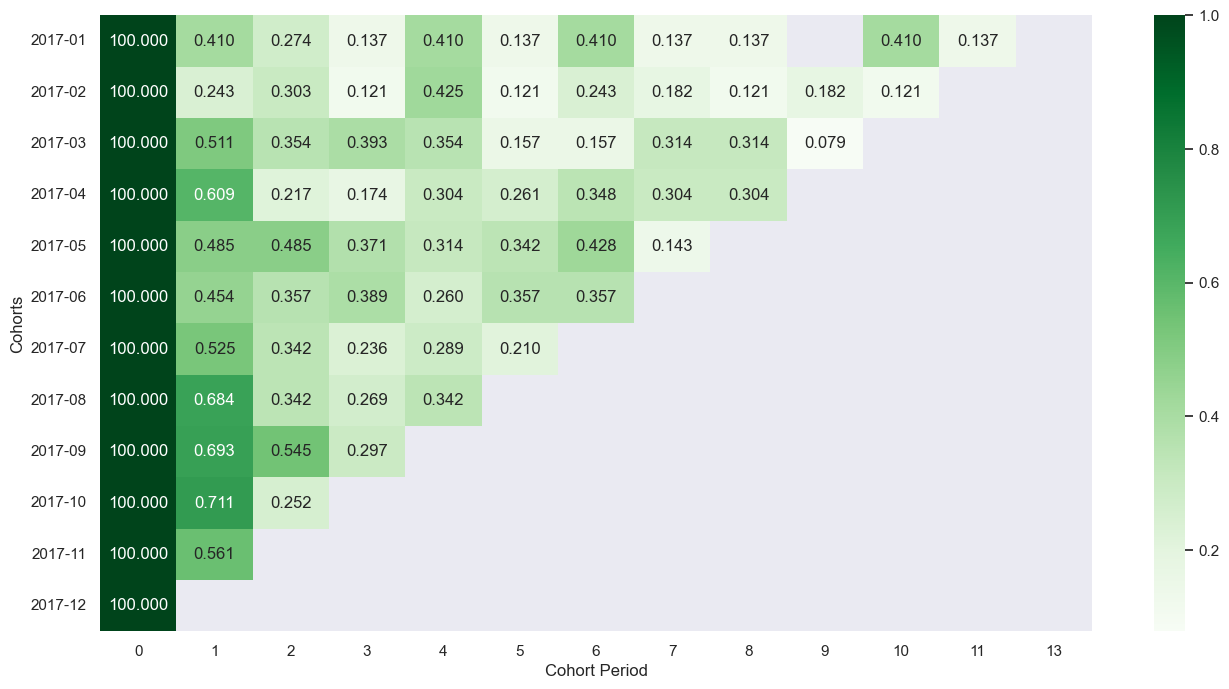

In [208]:
sns.set_style("dark")
plt.figure(figsize=(16,8))
ax=sns.heatmap(retention.iloc[2:,:], vmax=1, annot=True, fmt='.3f', cmap='Greens')
plt.xlabel('Cohort Period', size=12)
plt.ylabel('Cohorts', size=12)
plt.show()

**Answer**: 

The highest retention at month 3 was for the cohort that joined in March at 0.39%

---

### 6. Using Python, build an RFM-based user segmentation to assess your audience qualitatively. 
You can choose the following metrics in the clustering: 
- R - the time from the user's last purchase to the current date, 
- F - total number of purchases from the user over the entire time, 
- M - the sum of purchases for the whole time. 

Could you describe in detail how you created the clusters? 

For each RFM segment, construct the boundaries of the recency, frequency, and monetary metrics to interpret these clusters. 

*Example of such description: RFM-segment 132 (recency=1, frequency=3, monetary=2) has the boundaries of metrics recency from 130 to 500 days, frequency from 2 to 5 orders per week, and monetary from 1780 to 3560 USD per week.

Let's use the already created table `purchases_users`, which contains only records that we consider a purchase, as well as the unique id of the buyer.

In [209]:
purchases_users.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


Let's calculate the sum of each order

In [210]:
orders_price = items.groupby('order_id', as_index=False).agg({'price': 'sum'})

Let's add the sum to purchases and select only records from the last year of observations

In [211]:
start_date = purchases_users.order_purchase_timestamp.max() - timedelta(days=365)

In [212]:
purchases_price = purchases_users.merge(orders_price, on='order_id')
purchases_price = purchases_price.loc[purchases_price['order_purchase_timestamp'] >= start_date]
purchases_price.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,230.00
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,259.90


Let the current date be the day following the last observations

In [213]:
today = purchases_price['order_purchase_timestamp'].max() + timedelta(days=1)
today

Timestamp('2018-09-04 09:06:57')

Let's add column R - time from each user purchase to the current date, rounded to days

In [214]:
purchases_price['R'] = (today - purchases_price.order_purchase_timestamp).dt.days
purchases_price.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price,R
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,289.00,234
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,139.94,107
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,149.94,174
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,230.00,36
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,259.90,354


Let's group by unique user id and output the total number of:
- purchases from the user for the period of interest (F), 
- the time from the last purchase to the current date (R), 
- and the amount of money spent during the period of interest (M)

In [215]:
rfm = purchases_price.groupby('customer_unique_id', as_index=False) \
                    .agg({'R': 'min', 'order_id': 'count', 'price': 'sum'}) \
                    .rename(columns={'order_id': 'F', 'price': 'M'})
rfm.head()

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00


Let's explore R values

In [216]:
rfm.R.describe()

count    72722.000000
mean       176.570515
std         98.836206
min          1.000000
25%         92.000000
50%        176.000000
75%        264.000000
max        365.000000
Name: R, dtype: float64

We see that purchases are evenly distributed across the year of observation

Let's look at the top days by purchases

In [217]:
rfm.R.value_counts() 

R
283    1037
284     427
282     411
281     388
280     372
       ... 
246      59
253      55
6        39
5         9
1         1
Name: count, Length: 362, dtype: int64

The highest number of purchases appeared on the 283rd day from the current date, let's see what that day was:

In [218]:
today - timedelta(days=283)

Timestamp('2017-11-25 09:06:57')

The maximum number of purchases was on Black Friday

Let's look at the distribution of the number of purchases per year

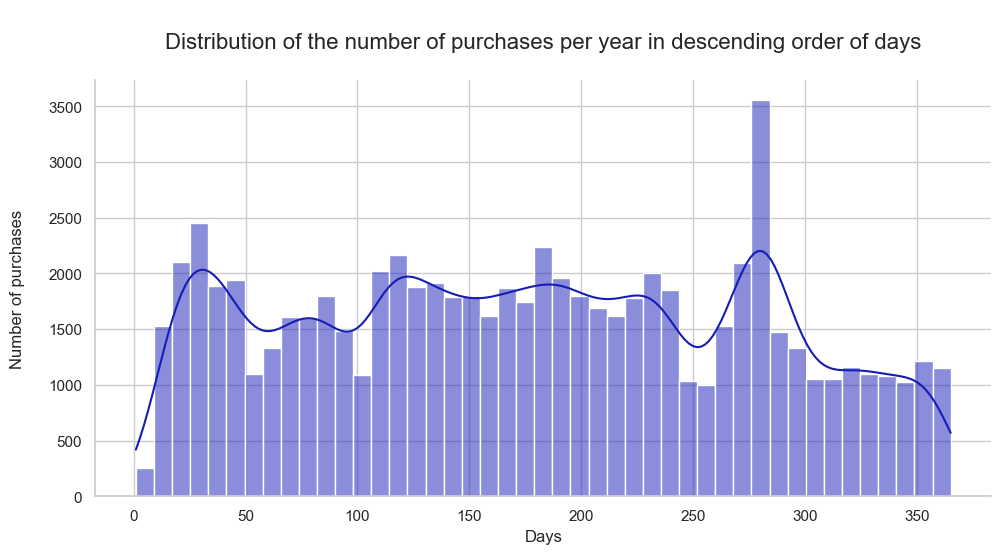

In [219]:
sns.set(style="whitegrid")

g = sns.displot(rfm['R'], kde=True, height=5, aspect=2, color='#161CB6')

plt.xlabel('Days')
plt.ylabel('Number of purchases\n')
plt.title('\nDistribution of the number of purchases per year in descending order of days\n', fontsize=16)

plt.show()


The highest point coincides with 283th day. The rest of the period is relatively evenly distributed with small ups and downs.

Let's look at the loyalty indicators

In [220]:
rfm.F.describe()

count    72722.000000
mean         1.027419
std          0.186128
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: F, dtype: float64

Most users have one purchase

Let's look at the top by number of purchases

In [221]:
rfm.F.value_counts()

F
1     70900
2      1702
3        94
4        16
5         5
7         3
9         1
11        1
Name: count, dtype: int64

Let's count how many users make multiple purchases

In [222]:
all_users = rfm.customer_unique_id.nunique()
users_over1 = rfm.loc[rfm.F > 1].customer_unique_id.nunique()
users_over2 = rfm.loc[rfm.F > 2].customer_unique_id.nunique()
print(f'{round(users_over1 * 100 / all_users, 2)}% of users ({users_over1}) made more than one purchase')
print(f'{round(users_over2 * 100 / all_users, 2)}% of users ({users_over2}) made more than two purchases')

2.51% of users (1822) made more than one purchase
0.17% of users (120) made more than two purchases


Let's look at the profitability metrics

In [223]:
rfm.M.describe()

count    72722.000000
mean       140.908235
std        211.365398
min          0.850000
25%         47.900000
50%         89.800000
75%        152.000000
max      13440.000000
Name: M, dtype: float64

Purchases vary from 0.85 to 13440 per purchase with a median of 89 and an average check of 141. Purchases for larger amounts on our platform are rare.

Let's look at users with the maximum amount of purchases

In [224]:
rfm.sort_values('M', ascending=False).head(10)

,customer_unique_id,R,F,M
2832,0a0a92112bd4c708ca5fde585afaa872,339,1,13440.00
33560,763c8b1c9c68a0229c42c9fc6f662b93,50,1,7160.00
19754,459bef486812aa25204be022145caa62,40,1,6729.00
18206,4007669dec559734d6f53e029e360987,283,1,5934.60
20689,48e1ac109decbb87765a3eade6854098,73,1,4590.00
46069,a229eba70ec1c2abef51f04987deb7a5,95,1,4400.00
67675,edde2314c6c30e864a128ac95d6b2112,31,1,4399.87
71165,fa562ef24d41361e476e748681810e1e,158,1,4099.99
56967,c8460e4251689ba205045f3ea17884a1,26,4,4080.00
57516,ca27f3dac28fb1063faddd424c9d95fa,37,1,4059.00


Users with the maximum check make purchases most often once and at different times of the year

We can also see that the maximum check differs from the average check by almost a hundred times

Since the 75th quartile is very close to the average, let's look at the number of users who buy ten times the average amount.

In [225]:
rfm.loc[rfm.M >= rfm.M.mean() * 10]

,customer_unique_id,R,F,M
96,005226be8d5b972d0f72b4e8a79f322b,155,1,1561.0
195,00adeda9b742746c0c66e10d00ea1b74,300,1,2078.5
224,00c07da5ba0e07b4f248a3a373b07476,38,1,2258.0
345,012a218df8995d3ec3bb221828360c86,77,2,1429.8
451,01858f2fad256b1689f5bdafc059f745,34,1,1799.0
...,...,...,...,...
71678,fc54c2c09aee36da48881e5bf37ef795,262,1,2680.0
72188,fe203d7588a60b447f5c5f089b967097,108,1,1599.0
72309,fe81bb32c243a86b2f86fbf053fe6140,74,5,1535.4
72368,fec38f6590f4d8e78563eacd15f0413c,149,1,1880.0


In [226]:
f'As a percentage of all users - {round(202 * 100 / all_users, 2)}'

'As a percentage of all users - 0.28'

These 202 people who shop for amounts ten times the average are a quarter of a percent of users 

#### Since users are more likely to make a single purchase, we are interested in highlighting users who:

- **new**: made a purchase recently
    - 25% of users have made a purchase in the past 92 days, get 1 point.
    - those before that - zero points
- **loyal**: have made more than one purchase
    - 1 point for two or more purchases
    - 0 for one
- **profitable**: spent more money
    - 25% of users who made a purchase greater than the 75th quantile get 1 point
    - 0 for less than 75th quantile
    
Let's calculate the score by adding R_score

In [227]:
quintiles = rfm['R'].quantile([.25, .5]).to_dict()

def r_score(x):
    if x <= quintiles[0.25]:
        return 1
    else:
        return 0

rfm['R_score'] = rfm.R.apply(r_score)
rfm.head()

,customer_unique_id,R,F,M,R_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0


Let's calculate the loyalty score by adding F_score

In [228]:
def f_score(x):
    if x > 1:
        return 1
    else:
        return 0


rfm['F_score'] = rfm.F.apply(f_score)
rfm.sort_values('F_score', ascending=False).head()

,customer_unique_id,R,F,M,R_score,F_score
63524,df2a9226267aa1598b499b3ea09fcf60,51,2,200.00,1,1
40959,9099c659f8cd764e87a1482d258fcec9,188,2,311.40,0,1
32712,731ea3afd190908a9cbed04f42aa51e2,280,2,269.70,0,1
32706,731a127666e5bc79810ebdc48eeff385,202,2,177.85,0,1
68492,f0e310a6839dce9de1638e0fe5ab282a,152,4,175.19,0,1


Let's calculate the profitability estimate by adding M_score

In [229]:
quintiles = rfm['M'].quantile([.75]).to_dict()
def m_score(x):
    if x >= quintiles[0.75]:
        return 1
    else:
        return 0

rfm['M_score'] = rfm.M.apply(m_score)
rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,1
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,1


In [230]:
r_scores = rfm['R_score'].value_counts().to_frame().reset_index()
f_scores = rfm['F_score'].value_counts().to_frame().reset_index()
m_scores = rfm['M_score'].value_counts().to_frame().reset_index()

In [231]:
r_scores

,R_score,count
0,0,54519
1,1,18203


Let's look at the distribution of our users across R_score, F_score, M_score:

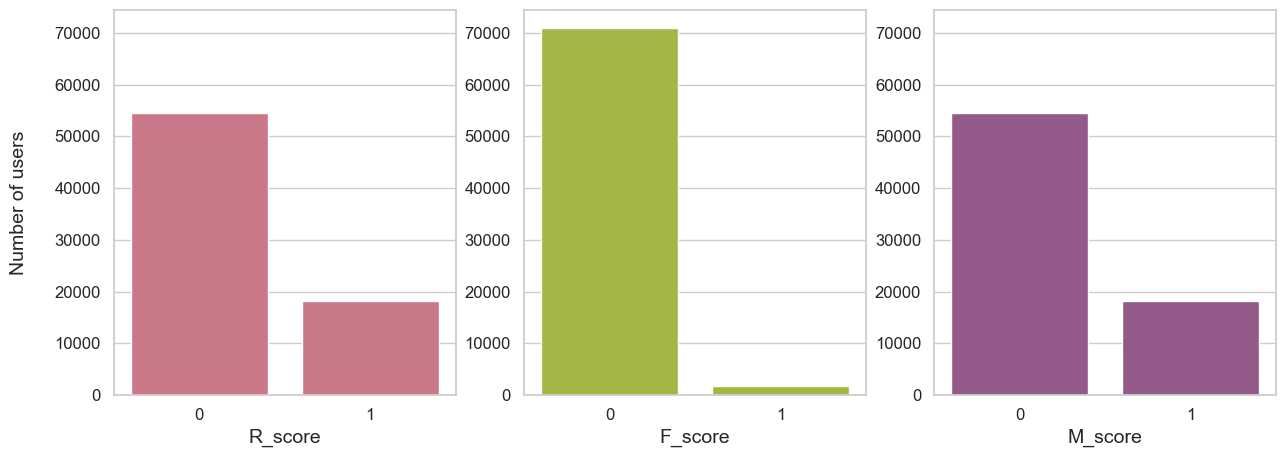

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style("white")

title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12

sns.barplot(data=r_scores, x='R_score', y='count', color='#D66B7F', ax=axes[0])
axes[0].set_ylabel('Number of users\n', fontsize=label_fontsize)
axes[0].set_xlabel('R_score', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

sns.barplot(data=f_scores, x='F_score', y='count', color='#B3C733', ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('F_score', fontsize=label_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

sns.barplot(data=m_scores, x='M_score', y='count', color='#9B5090', ax=axes[2])
axes[2].set_ylabel('')
axes[2].set_xlabel('M_score', fontsize=label_fontsize)
axes[2].tick_params(axis='both', labelsize=tick_fontsize)

y_max = max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(0, y_max)

plt.show()

The scores are distributed differently depending on the indicator:
- **R, Recentness**: about a quarter of users have made a purchase recently
- **F, Loyalty**: most users make one purchase. 2 or more are rare
- **M, Profitability**: about 2/3 of users make a purchase for less than the average check.

Most of our users are one-time buyers for a small amount of money

##### Let's calculate the full RFM_Score and RFM_Value for each user:

In [233]:
rfm['RFM_Score'] = rfm['R_score'].map(str) + rfm['F_score'].map(str) + rfm['M_score'].map(str)
rfm['RFM_Value'] = rfm.R_score + rfm.F_score + rfm.M_score
rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,RFM_Score,RFM_Value
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,000,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,000,0
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,000,0
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,1,001,1
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,1,001,1


We got 9 user groups

In [234]:
rfm['RFM_Score'].value_counts()

RFM_Score
000    40314
100    13494
001    12913
101     4179
011      777
010      515
111      328
110      202
Name: count, dtype: int64

The distribution of grades is as follows:

In [235]:
rfm['RFM_Value'].value_counts()

RFM_Value
0    40314
1    26922
2     5158
3      328
Name: count, dtype: int64

#### Let's define user segmentation:


* 111 - **"Champions "**, the best in everything 
* 101 - **"Valuable "** - made one purchase recently, but for an above average amount
* 011 - **"Important "** - made several above-average purchases.
* 110 - **"Hopeful "** - made several recent purchases
* 100 - **"New "** - made a one-time purchase recently
* 001 - **"Profitable "** - made an above-average one-time purchase.
* 010 - **"Loyal "** - made more than one purchase.
* 000 - **"One-time "** - made a one-time purchase a long time ago for a small amount.


In total, we have 8 groups.

Let's add segments for each user

In [236]:
def grouping(x):
    if x == '000':
        return "Разовые"
    elif x == '010':
        return "Лояльные"
    elif x == '001':
        return "Прибыльные"
    elif x == '100':
        return "Новые"
    elif x == '110':
        return "Подающие Надежды"
    elif x == '011':
        return "Важные"
    elif x == '101':
        return "Ценные"
    else:
        return "Чемпионы"


rfm['Group'] = rfm.RFM_Score.apply(grouping)

rfm.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,RFM_Score,RFM_Value,Group
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,000,0,Разовые
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,000,0,Разовые
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,000,0,Разовые
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,1,001,1,Прибыльные
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,1,001,1,Прибыльные


Let's group the segments by counting the number of users in each in absolute values and in percentages

In [237]:
rfm_g = rfm['Group'].value_counts().to_frame().reset_index().rename(columns={'index': 'Group', 'count': 'Users'}) \
                    .sort_values('Users')
rfm_g['Percentage'] = rfm_g['Users']/rfm_g['Users'].sum() * 100
rfm_g

,Group,Users,Percentage
7,Подающие Надежды,202,0.277770
6,Чемпионы,328,0.451033
5,Лояльные,515,0.708176
4,Важные,777,1.068452
3,Ценные,4179,5.746542
2,Прибыльные,12913,17.756662
1,Новые,13494,18.555595
0,Разовые,40314,55.435769


*New* and *Recent* users are the majority of our customers (35% in each group)

Let's display user segmentation

In [245]:
import plotly.graph_objects as go
fig = go.Figure()

colors = [ '#D66B7F', '#E4C725','#B3C733', 
                      '#367128', '#885E3A', '#924553', '#9B5090', '#7E5CA3']

domain=dict(x=[0, 0.5])

fig.add_trace(go.Funnel(
    x=rfm_g['Users'],
    y=rfm_g['Group'],
    orientation='h',
    textinfo='value+percent total',
    marker={'color': colors},
    customdata=rfm_g.apply(lambda row: \
                           f"{row['Group']}:<br>{row['Users']} users,<br>{row['Percentage']:.2f}% \
                           out of all users<extra></extra>", axis=1)
))


fig.update_layout(
    title={
        'text': 'User segmentation',
        'y': 0.86,
        'x': 0.58,
        'xanchor': 'center',
        'yanchor': 'top'},
    margin=dict(r=20, t=100)
)

fig.update_traces(hovertemplate='%{customdata}')

fig.show()

About 75% of users belong to the **"One-time"** and **"New "** segments. At the same time, the remaining 25% have a larger total check and more purchases than these two groups

Let's also look at the distribution of groups within each segment to see which group generates more revenue overall, as well as makes more purchases on average and has the highest median number of newcomers.

These are the factors that were chosen to be representative since:
- R, last user activity. We need to compare the average across groups, but making sure that outliers will not affect our data - we use the median.
- F, frequency of purchases. Here the data ranges from 1 to 9 with a maximum of one purchase, so the usual average is preferable - we get a decimal number unique to each group.
- M, profit. Here we are most interested in what income we received from the whole group, so we will choose the sum of all purchases.

In [239]:
groups = rfm.groupby('Group', as_index=False).agg({'R': 'median', 'F': 'mean', 'M': 'sum'})
groups['R'] = 365 - groups.R

groups['Color'] = [ '#924553', '#E4C725', '#9B5090', '#B3C733', '#367128',
                   '#7E5CA3', '#D66B7F', '#CB2A3A']

In [240]:
groups

,Group,R,F,M,Color
0,Важные,169.0,2.118404,284039.71,#924553
1,Лояльные,160.0,2.023301,49453.16,#E4C725
2,Новые,320.0,1.000000,950781.25,#9B5090
3,Подающие Надежды,318.0,2.029703,19450.75,#B3C733
4,Прибыльные,149.0,1.000000,4490951.40,#367128
5,Разовые,149.0,1.000000,2852949.35,#7E5CA3
6,Ценные,319.0,1.000000,1479275.95,#D66B7F
7,Чемпионы,318.0,2.189024,120227.12,#CB2A3A


Let's plot the distribution of segments for each parameter on the graph

In [248]:
R_sorted = groups.sort_values('R')
F_sorted = groups.sort_values('F')
M_sorted = groups.sort_values('M')

fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, 
        subplot_titles=['Distribution of segments by median accession time', 
                        'Distribution of segments by average number of purchases', 
                        'Segment allocation of total profit from the group'])

fig.add_trace(go.Bar(y=R_sorted['Group'], x=R_sorted['R'], orientation='h', 
                     marker=dict(color=R_sorted['Color']), name='R'), row=1, col=1)
fig.add_trace(go.Bar(y=F_sorted['Group'], x=F_sorted['F'], orientation='h', 
                     marker=dict(color=F_sorted['Color']), name='F'), row=2, col=1)
fig.add_trace(go.Bar(y=M_sorted['Group'], x=M_sorted['M'], orientation='h', 
                     marker=dict(color=M_sorted['Color']), name='M'), row=3, col=1)

fig.update_layout(height=900, showlegend=False, plot_bgcolor="white", paper_bgcolor="#F6FAFF")
fig.update_xaxes(showline=True, linewidth=1, gridcolor='#D4F2FF')
fig.update_yaxes(showline=True, linewidth=2, gridcolor="#F6FAFF")

fig.show()


### Conclusions and observations

**"Champions "** are the leaders in the number of purchases, but due to the extremely small number of users, they bring a small total profit.

**"Hopeful", "Loyal" and "Important "** users share the top in terms of average number of purchases, but also bring a small total profit.

At the same time, the maximum profit is brought to us by the **"Profitable "** segment with a gap of almost one third from the largest by number segments - **"Valuable" and "One-time "**. 

In the future, we can conduct a more detailed analysis for each segment to identify behavior patterns and possible points of influence on users. Based on these, we can develop and implement marketing campaigns aimed at: 
- Expanding the number of new customers, as they make up the bulk of our audience,
- attracting customers to repeat purchases in order to convert them into loyal segments,
- retaining customers in the zone of interest and potential, 
- increasing the number of sales to large customers to increase the total revenue they generate,
- rewarding the best customers.
